In [1]:
import os
import re
import numpy as np
import pandas as pd
import pickle
# from googletrans import Translator
from cleantext import clean
import seaborn as sns
from matplotlib import pyplot as plt
from dython import nominal
from scipy.stats import f_oneway
import scipy

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, FeatureHasher, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sharhad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [207]:
nDAY = r'(?:[0-3]?\d)'  # day can be from 1 to 31 with a leading zero 
nMNTH = r'(?:11|12|10|0?[1-9])' # month can be 1 to 12 with a leading zero
nYR = r'(?:(?:19|20)\d\d)'  # I've restricted the year to being in 20th or 21st century on the basis 
                            # that people doon't generally use all number format for old dates, but write them out 
nDELIM = r'(?:[\/\-\._])?'  # 
NUM_DATE = f"""
    (?P<num_date>
        (?:^|\D) # new bit here
        (?:
        # YYYY-MM-DD
        (?:{nYR}(?P<delim1>[\/\-\._]?){nMNTH}(?P=delim1){nDAY})
        |
        # YYYY-DD-MM
        (?:{nYR}(?P<delim2>[\/\-\._]?){nDAY}(?P=delim2){nMNTH})
        |
        # DD-MM-YYYY
        (?:{nDAY}(?P<delim3>[\/\-\._]?){nMNTH}(?P=delim3){nYR})
        |
        # MM-DD-YYYY
        (?:{nMNTH}(?P<delim4>[\/\-\._]?){nDAY}(?P=delim4){nYR})
        )
        (?:\D|$) # new bit here
    )"""
DAY = r"""
(?:
    # search 1st 2nd 3rd etc, or first second third
    (?:[23]?1st|2{1,2}nd|\d{1,2}th|2?3rd|first|second|third|fourth|fifth|sixth|seventh|eighth|nineth)
    |
    # or just a number, but without a leading zero
    (?:[123]?\d)
)"""
MONTH = r'(?:january|february|march|april|may|june|july|august|september|october|november|december|jan|feb|mar|apr|may|jun|jul|aug|sep|sept|oct|nov|dec)'
YEAR = r"""(?:(?:[12]?\d|')?\d\d)"""
DELIM = r'(?:\s*(?:[\s\.\-\\/,]|(?:of))\s*)'

YEAR_4D = r"""(?:[12]\d\d\d)"""
DATE_PATTERN = f"""(?P<wordy_date>
    # non word character or start of string
    (?:^|\W)
        (?:
            # match various combinations of year month and day 
            (?:
                # 4 digit year
                (?:{YEAR_4D}{DELIM})?
                    (?:
                    # Day - Month
                    (?:{DAY}{DELIM}{MONTH})
                    |
                    # Month - Day
                    (?:{MONTH}{DELIM}{DAY})
                    )
                # 2 or 4 digit year
                (?:{DELIM}{YEAR})?
            )
            |
            # Month - Year (2 or 3 digit)
            (?:{MONTH}{DELIM}{YEAR})
        )
    # non-word character or end of string
    (?:$|\W)
)"""

TIME = r"""(?:
(?:
# first number should be 0 - 59 with optional leading zero.
[012345]?\d
# second number is the same following a colon
:[012345]\d
)
# next we add our optional seconds number in the same format
(?::[012345]\d)?
# and finally add optional am or pm possibly with . and spaces
(?:\s*(?:a|p)\.?m\.?)?
)"""

COMBINED = f"""(?P<combined>
    (?:
        # time followed by date, or date followed by time
        {TIME}?{DATE_PATTERN}{TIME}?
        |
        # or as above but with the numeric version of the date
        {TIME}?{NUM_DATE}{TIME}?
    ) 
    # or a time on its own
    |
    (?:{TIME})
)"""

date = re.compile(COMBINED, re.IGNORECASE | re.VERBOSE | re.UNICODE)

date.findall('10-19-19 - The CMS Highlight Show')

[]

In [3]:
def get_en(filename, save_file = False, save_path = ''):
    df = pd.DataFrame(filename)
    df[df['Language'] == 'en']
    if save_file:
        df.to_csv(save_path)
    return df

def read_csv(filename, to_drop = []):
    df = pd.read_csv(filename)
    df = df.drop(to_drop, axis = 1)
    return df

In [15]:
clean('asdasdasd')

'asdasdasd'

In [4]:
data_path = '../data/'
# df = get_en(os.path.join(data_path, 'Podcasts.csv'), 
#             save_file = True, 
#             save_path = os.path.join(data_path, 'Podcasts_en.csv'))
df = read_csv(os.path.join(data_path, 'Podcasts_en.csv'), 
              to_drop = ['Unnamed: 0', 'ContentUrl', 'Country', 'Language'])
df.head()

,podcastname,stylename,Title,Duration
0,The CMS Network,Comedy,10-19-19 - The CMS Highlight Show,1041.0
1,The CMS Network,Comedy,SS- Episode#37: Ritchie Blackmore’s Rainbow Ca...,5201.0
2,The CMS Network,Comedy,"Inclusiveness, Diversity And The Redistributio...",3485.0
3,The CMS Network,Comedy,10-12-19 - The CMS Highlight Show,2461.0
4,The CMS Network,Comedy,Episode#36-Parris Mayhew (Cro-Mags) pt.2,4495.0


In [5]:
def drop_cat(df, n = 10):
    cat = df['stylename'].value_counts()
    cat_to_drop = list(cat[cat < n].index)
    cat_to_drop.append('Miscellaneous')
    df = df[~df['stylename'].isin(cat_to_drop)]
    return df

def augment_cols(df):
    df['name_title'] = df['podcastname'].astype(str) + ' ' + df['Title'].astype(str)
    df['target'], map = pd.factorize(df['stylename'])
    map = dict(zip(range(len(map)), map))
    with open(os.path.join(data_path, 'cat_mapping_en.pkl'), 'wb') as file:
        pickle.dump(map, file, protocol = pickle.HIGHEST_PROTOCOL)
    return df 

def clean_data(df, translate = False):
    translator = Translator()
    lemmatizer = WordNetLemmatizer()
    
    if translate: 
        df['name_title'] = df['name_title'].apply(lambda x: translator.translate(x, dest = 'en'))
    # df['name_title'] = df['name_title'].apply(lambda x: re.sub(date, ' ', x))
    df['name_title'] = df['name_title'].str.replace('[^A-Za-z0-9 ]+', ' ')
    df['name_title'] = df['name_title'].apply(lambda x: clean(x, clean_all = False, 
                                                              extra_spaces = True,                                                   
                                                              stemming = False,
                                                              stopwords = True,
                                                              lowercase = True,
                                                              numbers = True,
                                                              punct = True))
    
    df['name_title'] = df['name_title'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    df = df.dropna()
    return df

def save_df(df, save_path):
    df.to_csv(save_path, index = None)

In [6]:
df = drop_cat(df)
df = augment_cols(df)
df.head()
# df = clean_data(df)
# save_df(df, os.path.join(data_path, 'podcasts_en_processed.csv'))


,podcastname,stylename,Title,Duration,name_title,target
0,The CMS Network,Comedy,10-19-19 - The CMS Highlight Show,1041.0,The CMS Network 10-19-19 - The CMS Highlight Show,0
1,The CMS Network,Comedy,SS- Episode#37: Ritchie Blackmore’s Rainbow Ca...,5201.0,The CMS Network SS- Episode#37: Ritchie Blackm...,0
2,The CMS Network,Comedy,"Inclusiveness, Diversity And The Redistributio...",3485.0,"The CMS Network Inclusiveness, Diversity And T...",0
3,The CMS Network,Comedy,10-12-19 - The CMS Highlight Show,2461.0,The CMS Network 10-12-19 - The CMS Highlight Show,0
4,The CMS Network,Comedy,Episode#36-Parris Mayhew (Cro-Mags) pt.2,4495.0,The CMS Network Episode#36-Parris Mayhew (Cro-...,0


In [2]:
def bag_of_words(X, col = 'name_title'):
    vectorizer = CountVectorizer(stop_words = 'english')
    X = vectorizer.fit_transform(X)
    return X

def one_hot_encoding(X, col = 'name_title'):
    one_hot_encoder = OneHotEncoder()
    X = X.values.reshape(-1, 1)
    X = one_hot_encoder.fit_transform(X)
    return X

def word_2_vector(X):
    w2v_model = gensim.models.Word2Vec(X, vector_size = 100, window = 5, min_count = 2)

def glove(X):
    return X

def tfidf(X, col = 'name_title'):
    tfidf_vectorizer = TfidfVectorizer(max_df = 0.8, max_features = 10000)
    return tfidf_vectorizer.fit_transform(X[col])

def countvector_tfidtransform(X, col = ''):
    cv = CountVectorizer(stop_words = 'english')
    tfidf = TfidfTransformer()
    X = cv.fit_transform(X[col])
    return tfidf.fit_transform(X)
    # pipeline = Pipeline([
    #     ('vect', CountVectorizer(stop_words = 'english')),
    #     ('tfidf', TfidfTransformer()),
    # ])
    # return pipeline.fit_transform(X)
    

In [6]:
def logistic_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    lr = LogisticRegression(C = 100.0, random_state = 1, solver = 'lbfgs', multi_class = 'ovr')
    lr.fit(X_train, y_train)
    y_predict = lr.predict(X_test)
    print(y_predict)
    print("Logistic Regression Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def sgd_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    sgd = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 1e-3, random_state = 42, max_iter = 20, tol = None)
    sgd.fit(X_train, y_train)
    y_predict = sgd.predict(X_test)
    print("SGD Classifier Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def linear_svc(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    lsvc = LinearSVC()
    lsvc.fit(X_train, y_train)
    y_predict = lsvc.predict(X_test)
    print("Linear SVC Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def knn(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    print("K Neighbors Classifier Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def tree(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)
    y_predict = tree.predict(X_test)
    print("Decision Tree Classifier Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def nn(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    nn = MLPClassifier(n_neighbors = 3)
    nn.fit(X_train, y_train)
    y_predict = nn.predict(X_test)
    print("MLP Classifier Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def naive_bayes(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    y_predict = nb.predict(X_test)
    print("Naive Bayes Classifier Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def random_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train, y_train)
    y_predict = random_forest.predict(X_test)
    print("Random Forest Classifier Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
    

In [7]:
def normalize(df, col = 'Duration'):
    mms = MinMaxScaler()
    mms_col = mms.fit_transform(df[col].values.reshape(-1, 1))
    return mms_col

def get_training_data(df):
    df = shuffle(pd.read_csv(df).dropna())
    data = df[['name_title', 'Duration']]
    X_duration = normalize(data, col = 'Duration')
    X = scipy.sparse.hstack((countvector_tfidtransform(data, col = 'name_title'),
                             scipy.sparse.csr_matrix(X_duration)))
    y = df['target']
    return X, y

In [8]:
# df = shuffle(pd.read_csv(os.path.join(data_path, 'podcasts_en_processed.csv')).dropna())

# X = df['name_title']
# y = df['target']
# X = countvector_tfidtransform(X)
data_path = '../data/'
# X, y = get_training_data(os.path.join(data_path, 'podcasts_en_processed.csv'))

# print(X.shape)
# random_forest(X, y)

In [9]:
# X, y = get_training_data(os.path.join(data_path, 'podcasts_en_processed.csv'))
df = shuffle(pd.read_csv(os.path.join(data_path, 'podcasts_en_processed.csv')).dropna())

X = df['name_title']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
clf = Pipeline([
     ('vect', CountVectorizer(stop_words = 'english')),
     ('tfidf', TfidfTransformer()),
     ('clf', RandomForestClassifier()
)])

clf.fit(X, y)
pickle.dump(clf, open('model.pkl', 'wb'))
y_predict = clf.predict(X_test)
print('Classifier Accuracy %.3f' %metrics.accuracy_score(y_test, y_predict))
print('Balanced Classifier Accuracy %.3f' %metrics.balanced_accuracy_score(y_test, y_predict))
print('f1_score %.3f' %metrics.f1_score(y_test, y_predict, average = 'micro'))
print('Precision %.3f' %metrics.precision_score(y_test, y_predict, average = 'micro'))
print('Recall %.3f' %metrics.recall_score(y_test, y_predict, average = 'micro'))
cf_matrix = metrics.confusion_matrix(y_test, y_predict)

sns.heatmap(cf_matrix, annot = True, fmt='.2%', cmap = 'Blues')


Classifier Accuracy 1.000
Balanced Classifier Accuracy 1.000
f1_score 1.000
Precision 1.000
Recall 1.000


TypeError: confusion_matrix() got an unexpected keyword argument 'average'

array([2])

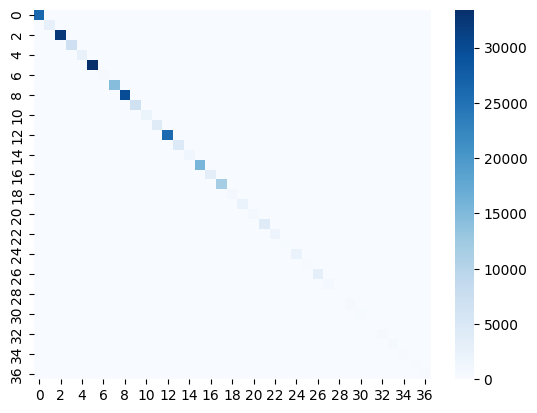

In [11]:
cf_matrix = metrics.confusion_matrix(y_test, y_predict)

sns.heatmap(cf_matrix, fmt='.2%', cmap = 'Blues')

clf.predict(['tate speech tate best book ever'])

In [12]:
loaded_model = pickle.load(open('model.pkl', 'rb'))

In [14]:
loaded_model.predict(['tate speech tate best book ever'])[0]

2

In [ ]:
Fantasy Baseball Today
04/03 Fantasy Baseball Podcast: Closer Problems Already?
Baseball
4